<center>
<h1> Python for finance and optimization </h1>
<h2> Portfolio Strategies Project </h1>
<h2> By : </h2>
<h3> - BULAHIA Youssef </h2>

#### <blockquote> The main purpose of the project is to build 3 types of portolio according to 3 different strategies for investments. </blockquote>
#### <blockquote> The investment is based on data of SBF 120 components from the Excel file provided.

### Downloading packages and libraries needed for our project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
import matplotlib.ticker as ticker #to change graph axes
from datetime import date #for date manipulation
from sklearn.covariance import EmpiricalCovariance #to calculate the empirical covariance
import riskfolio as rp #library that imports the ERC portfolio model
from scipy.optimize import minimize #to omptimize function

<h3> Data Analysis </h3>

#### In the first part, we are going to prepare our data (generate dates and fill the missing values) in order to find the 10 stocks corresponding to those having the highest market capitalization as of end 2018.

In [4]:
data_ticker= pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx')
data_ticker.set_index('Ticker', inplace = True)
data_ticker

,Name
Ticker,
QDT FP Equity,Quadient SA
DIM FP Equity,Sartorius Stedim Biotech
RUI FP Equity,Rubis SCA
OR FP Equity,L'Oreal SA
DG FP Equity,Vinci SA
...,...
RCO FP Equity,Remy Cointreau SA
STM FP Equity,STMicroelectronics NV
ATE FP Equity,Alten SA


In [5]:
data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name='Data')
data

,QDT FP Equity,PX_LAST,MARKETCAP,DIM FP Equity,PX_LAST.1,MARKETCAP.1,RUI FP Equity,PX_LAST.2,MARKETCAP.2,OR FP Equity,...,MARKETCAP.116,ATE FP Equity,PX_LAST.117,MARKETCAP.117,WLN FP Equity,PX_LAST.118,MARKETCAP.118,NXI FP Equity,PX_LAST.119,MARKETCAP.119
0,40543,65.20,2074.1424,40543,6.28,640.6889,40543,21.1225,1224.8148,40543,...,7045.2320,40543,24.585,785.1392,41816.0,16.4,NaN,40543,26.4957,1770.6669
1,40546,65.41,2080.8229,40546,6.29,641.5386,40546,21.3261,1236.6203,40546,...,7356.5732,40546,24.700,788.8118,41817.0,16.4,2160.9760,40546,26.8603,1795.0327
2,40547,66.54,2116.7705,40547,6.28,640.6889,40547,21.3770,1239.5716,40547,...,7370.2285,40547,25.090,801.2667,41820.0,16.6,2187.3294,40547,27.2288,1819.6576
3,40548,66.51,2115.8161,40548,6.29,641.3687,40548,21.6896,1257.7014,40548,...,7544.1062,40548,25.000,798.3925,41821.0,16.4,2160.9760,40548,27.1047,1811.3629
4,40549,67.56,2149.2187,40549,6.30,642.3883,40549,21.6920,1257.8420,40549,...,7652.4383,40549,25.450,812.7636,41822.0,16.3,2147.7993,40549,27.1861,1816.8063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,44440,23.72,819.8323,44440,524.20,48320.8556,44440,33.2700,3459.1215,44440,...,34554.1988,44440,138.700,4765.8506,NaN,NaN,NaN,44440,43.5800,2446.1334
2730,44441,23.76,821.2148,44441,532.60,49095.1692,44441,33.2000,3451.8435,44441,...,34567.8674,44441,139.900,4807.0836,NaN,NaN,NaN,44441,43.3600,2433.7848
2731,44442,23.28,804.6246,44442,531.00,48947.6809,44442,32.9700,3427.9301,44442,...,34535.9740,44442,139.800,4803.6475,NaN,NaN,NaN,44442,43.6600,2450.6237
2732,44445,22.80,788.0344,44445,542.40,49998.5351,44445,33.0000,3431.0493,44445,...,34804.7896,44445,138.700,4765.8506,NaN,NaN,NaN,44445,43.6200,2448.3786


Indexing our data with dates after generating them, renaming each column so that we will have equity columns et marketcap columns.

In [6]:
data_list = []
for i in tqdm(range(120)):
    price_mktcap_data = data.iloc[:,3*i:3*i+3].copy()
    price_mktcap_data.dropna(inplace=True)
    price_mktcap_data.iloc[:,0] = pd.to_datetime(price_mktcap_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    price_mktcap_data.rename(columns = {price_mktcap_data.columns[0] : 'Date', price_mktcap_data.columns[1]: price_mktcap_data.columns[0] + ' PX', price_mktcap_data.columns[2]: price_mktcap_data.columns[0] + ' MKTCAP'}, inplace = True)
    price_mktcap_data.set_index('Date', inplace = True)
    data_list.append(price_mktcap_data)
agg_data = data_list[0]
for df1 in tqdm(data_list[1:]):
    agg_data = agg_data.join(df1, how='outer', sort = True)
agg_data.sort_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 180.73it/s]


,QDT FP Equity PX,QDT FP Equity MKTCAP,DIM FP Equity PX,DIM FP Equity MKTCAP,RUI FP Equity PX,RUI FP Equity MKTCAP,OR FP Equity PX,OR FP Equity MKTCAP,DG FP Equity PX,DG FP Equity MKTCAP,...,RCO FP Equity PX,RCO FP Equity MKTCAP,STM FP Equity PX,STM FP Equity MKTCAP,ATE FP Equity PX,ATE FP Equity MKTCAP,WLN FP Equity PX,WLN FP Equity MKTCAP,NXI FP Equity PX,NXI FP Equity MKTCAP
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,65.20,2074.1424,6.28,640.6889,21.1225,1224.8148,83.08,49784.4831,40.2799,22463.6902,...,51.1749,2603.4359,7.739,7045.2320,24.585,785.1392,NaN,NaN,26.4957,1770.6669
2011-01-03,65.41,2080.8229,6.29,641.5386,21.3261,1236.6203,85.50,51234.6330,41.3097,23037.9831,...,51.4648,2618.1862,8.081,7356.5732,24.700,788.8118,NaN,NaN,26.8603,1795.0327
2011-01-04,66.54,2116.7705,6.28,640.6889,21.3770,1239.5716,85.04,50958.9847,41.0176,22875.0827,...,51.2522,2607.3693,8.096,7370.2285,25.090,801.2667,NaN,NaN,27.2288,1819.6576
2011-01-05,66.51,2115.8161,6.29,641.3687,21.6896,1257.7014,84.66,50731.2752,40.4730,22571.3701,...,52.0833,2649.6536,8.287,7544.1062,25.000,798.3925,NaN,NaN,27.1047,1811.3629
2011-01-06,67.56,2149.2187,6.30,642.3883,21.6920,1257.8420,84.57,50677.3440,39.9878,22317.5758,...,51.3198,2610.8110,8.406,7652.4383,25.450,812.7636,NaN,NaN,27.1861,1816.8063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,23.72,819.8323,524.20,48320.8556,33.2700,3459.1215,399.50,222789.8633,93.7500,56029.0137,...,170.0000,8589.5157,37.920,34554.1988,138.700,4765.8506,75.99,21312.5103,43.5800,2446.1334
2021-09-02,23.76,821.2148,532.60,49095.1692,33.2000,3451.8435,400.15,223152.3500,92.9800,55568.8288,...,170.9000,8634.9896,37.935,34567.8674,139.900,4807.0836,75.01,21037.6549,43.3600,2433.7848
2021-09-03,23.28,804.6246,531.00,48947.6809,32.9700,3427.9301,394.85,220196.6897,91.1400,54469.1660,...,168.6000,8518.7785,37.900,34535.9740,139.800,4803.6475,72.39,20302.8375,43.6600,2450.6237


In [7]:
#filtering the data as of end 2018
agg_price_mktcap_data_2018 = agg_data[(agg_data.index <= '31/12/2018')]
agg_price_mktcap_data_2018

/var/folders/ct/1jcf3_210l7761kmjs9wb7km0000gn/T/ipykernel_43464/3538645376.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  agg_price_mktcap_data_2018 = agg_data[(agg_data.index <= '31/12/2018')]


,QDT FP Equity PX,QDT FP Equity MKTCAP,DIM FP Equity PX,DIM FP Equity MKTCAP,RUI FP Equity PX,RUI FP Equity MKTCAP,OR FP Equity PX,OR FP Equity MKTCAP,DG FP Equity PX,DG FP Equity MKTCAP,...,RCO FP Equity PX,RCO FP Equity MKTCAP,STM FP Equity PX,STM FP Equity MKTCAP,ATE FP Equity PX,ATE FP Equity MKTCAP,WLN FP Equity PX,WLN FP Equity MKTCAP,NXI FP Equity PX,NXI FP Equity MKTCAP
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,65.20,2074.1424,6.28,640.6889,21.1225,1224.8148,83.08,49784.4831,40.2799,22463.6902,...,51.1749,2603.4359,7.739,7045.2320,24.585,785.1392,NaN,NaN,26.4957,1770.6669
2011-01-03,65.41,2080.8229,6.29,641.5386,21.3261,1236.6203,85.50,51234.6330,41.3097,23037.9831,...,51.4648,2618.1862,8.081,7356.5732,24.700,788.8118,NaN,NaN,26.8603,1795.0327
2011-01-04,66.54,2116.7705,6.28,640.6889,21.3770,1239.5716,85.04,50958.9847,41.0176,22875.0827,...,51.2522,2607.3693,8.096,7370.2285,25.090,801.2667,NaN,NaN,27.2288,1819.6576
2011-01-05,66.51,2115.8161,6.29,641.3687,21.6896,1257.7014,84.66,50731.2752,40.4730,22571.3701,...,52.0833,2649.6536,8.287,7544.1062,25.000,798.3925,NaN,NaN,27.1047,1811.3629
2011-01-06,67.56,2149.2187,6.30,642.3883,21.6920,1257.8420,84.57,50677.3440,39.9878,22317.5758,...,51.3198,2610.8110,8.406,7652.4383,25.450,812.7636,NaN,NaN,27.1861,1816.8063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,23.98,828.8186,82.50,7604.8657,44.9200,4353.6232,200.70,112463.3236,71.4200,42672.6924,...,96.4834,4952.3193,12.030,10961.1574,71.650,2423.9523,40.60,7411.7296,39.2600,2203.6530
2018-12-24,23.34,806.6984,84.95,7830.7071,44.8200,4343.9312,197.65,110754.2397,70.5000,42123.0022,...,97.3768,4998.1741,11.850,10797.1500,71.100,2405.3456,40.58,7408.0785,39.5400,2219.3693
2018-12-27,23.06,797.0208,82.05,7563.3846,44.7800,4340.0545,195.60,109605.5112,70.6400,42206.6507,...,96.1360,4934.4869,11.870,10815.3731,70.500,2385.0473,40.14,7327.7544,38.1600,2141.9103


In [8]:
#number of missing values per column
null_data_dict = agg_price_mktcap_data_2018.apply(lambda column: column.isna().sum()).to_dict()
null_data_dict

{'QDT FP Equity PX': 0,
 'QDT FP Equity MKTCAP': 0,
 'DIM FP Equity PX': 0,
 'DIM FP Equity MKTCAP': 0,
 'RUI FP Equity PX': 2,
 'RUI FP Equity MKTCAP': 2,
 'OR FP Equity PX': 0,
 'OR FP Equity MKTCAP': 0,
 'DG FP Equity PX': 0,
 'DG FP Equity MKTCAP': 0,
 'ALD FP Equity PX': 1653,
 'ALD FP Equity MKTCAP': 1653,
 'URW NA Equity PX': 0,
 'URW NA Equity MKTCAP': 0,
 'KORI FP Equity PX': 0,
 'KORI FP Equity MKTCAP': 0,
 'TTE FP Equity PX': 0,
 'TTE FP Equity MKTCAP': 0,
 'DSY FP Equity PX': 2,
 'DSY FP Equity MKTCAP': 2,
 'AI FP Equity PX': 0,
 'AI FP Equity MKTCAP': 0,
 'ERF FP Equity PX': 1,
 'ERF FP Equity MKTCAP': 1,
 'CS FP Equity PX': 0,
 'CS FP Equity MKTCAP': 0,
 'BNP FP Equity PX': 0,
 'BNP FP Equity MKTCAP': 0,
 'BB FP Equity PX': 0,
 'BB FP Equity MKTCAP': 0,
 'BN FP Equity PX': 0,
 'BN FP Equity MKTCAP': 0,
 'CAP FP Equity PX': 2,
 'CAP FP Equity MKTCAP': 2,
 'CA FP Equity PX': 0,
 'CA FP Equity MKTCAP': 0,
 'CGG FP Equity PX': 2,
 'CGG FP Equity MKTCAP': 2,
 'GNFT FP Equity P

In [9]:
#filling the missing values using the barckward fill
for column in tqdm(agg_price_mktcap_data_2018.columns):
    series = agg_price_mktcap_data_2018[column]
    first = series.first_valid_index()
    last = series.last_valid_index()
    series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
    agg_price_mktcap_data_2018[column][(agg_price_mktcap_data_2018[column].index >= first) & (agg_price_mktcap_data_2018[column].index <= last)] = series_real

  0%|                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]/var/folders/ct/1jcf3_210l7761kmjs9wb7km0000gn/T/ipykernel_43464/2766121420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_price_mktcap_data_2018[column][(agg_price_mktcap_data_2018[column].index >= first) & (agg_price_mktcap_data_2018[column].index <= last)] = series_real
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 610.45it/s]


In [10]:
#columns with large number of missing values
null_data_dict = agg_price_mktcap_data_2018.apply(lambda column: column.isna().sum())
null_data_dict = null_data_dict.to_dict()
stocks_null = [key for key, value in null_data_dict.items() if value!=0]
stocks_null

['ALD FP Equity PX',
 'ALD FP Equity MKTCAP',
 'EUCAR FP Equity PX',
 'EUCAR FP Equity MKTCAP',
 'ENX FP Equity PX',
 'ENX FP Equity MKTCAP',
 'FNAC FP Equity PX',
 'FNAC FP Equity MKTCAP',
 'AMUN FP Equity PX',
 'AMUN FP Equity MKTCAP',
 'SPIE FP Equity PX',
 'SPIE FP Equity MKTCAP',
 'FTI FP Equity PX',
 'FTI FP Equity MKTCAP',
 'GTT FP Equity PX',
 'GTT FP Equity MKTCAP',
 'ELIS FP Equity PX',
 'ELIS FP Equity MKTCAP',
 'ELIOR FP Equity PX',
 'ELIOR FP Equity MKTCAP',
 'DBV FP Equity PX',
 'DBV FP Equity MKTCAP',
 'TKTT FP Equity PX',
 'TKTT FP Equity MKTCAP',
 'APAM NA Equity PX',
 'APAM NA Equity MKTCAP',
 'MDM FP Equity PX',
 'MDM FP Equity MKTCAP',
 'WLN FP Equity PX',
 'WLN FP Equity MKTCAP']

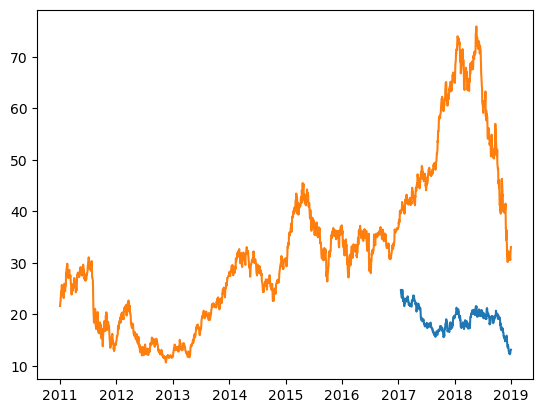

In [11]:
#plot 2 differents tickers in order to show the gap of data of some tickers
plt.plot(agg_price_mktcap_data_2018['FTI FP Equity PX'])
plt.plot(agg_price_mktcap_data_2018['EO FP Equity PX'])
plt.show()

Droping the stocks with huge data gap. Then, filtering the stocks to reduce our investment universe to 10 stocks corresponding to those having the highest market capitalization as of end 2018

In [12]:
agg_price_mktcap_data_2018 = agg_price_mktcap_data_2018.drop(columns = stocks_null)
mk_data_list = []
for i in tqdm(range(105)):
    mk_data = pd.DataFrame(data = agg_price_mktcap_data_2018.iloc[:,2*i:2*i+2].sum().copy())
    mk_data.rename(columns = {mk_data.columns[0] : mk_data.index[0]}, inplace = True)
    mk_data = mk_data.drop(mk_data.index[0])
    mk_data = mk_data.transpose()
    mk_data.rename(columns = {mk_data.columns[0] : 'MARKETCAP TOTAL'}, inplace = True)
    mk_data_list.append(mk_data)
agg_mk_data = mk_data_list[0].transpose()
for df1 in tqdm(mk_data_list[1:]):
    agg_mk_data = agg_mk_data.join(df1.transpose(), how='outer', sort = True)
agg_mk_data_10 = agg_mk_data.transpose().sort_values(by='MARKETCAP TOTAL', ascending=False).head(10)
agg_mk_data_10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 568.13it/s]


,MARKETCAP TOTAL
TTE FP Equity PX,2.184987e+08
SAN FP Equity PX,1.940611e+08
MC FP Equity PX,1.704167e+08
OR FP Equity PX,1.660428e+08
BNP FP Equity PX,1.262975e+08
CS FP Equity PX,9.215842e+07
AIR FP Equity PX,8.601526e+07
ENGI FP Equity PX,8.255748e+07
BN FP Equity PX,7.688962e+07
EDF FP Equity PX,7.246523e+07


In [13]:
#building a DataFrame that contains the 10 stocks chosen with the corresponding prices and marketcaps
agg_price_mktcap_data_over_2019 = agg_data.loc['2019']
list_index = []
for column in list(agg_mk_data_10.index):
    list_index.append(agg_price_mktcap_data_over_2019.columns.get_loc(column))
    list_index.append(agg_price_mktcap_data_over_2019.columns.get_loc(column)+1)
col_index_map = {col_name: i for i, col_name in enumerate(agg_price_mktcap_data_over_2019.columns)}
highest_columns_10 = [key for key, value in col_index_map.items() if value in list_index]
agg_price_mktcap_data_2019_10_highest = agg_price_mktcap_data_over_2019[highest_columns_10]
agg_price_mktcap_data_2019_10_highest

,OR FP Equity PX,OR FP Equity MKTCAP,TTE FP Equity PX,TTE FP Equity MKTCAP,CS FP Equity PX,CS FP Equity MKTCAP,BNP FP Equity PX,BNP FP Equity MKTCAP,BN FP Equity PX,BN FP Equity MKTCAP,MC FP Equity PX,MC FP Equity MKTCAP,ENGI FP Equity PX,ENGI FP Equity MKTCAP,EDF FP Equity PX,EDF FP Equity MKTCAP,SAN FP Equity PX,SAN FP Equity MKTCAP,AIR FP Equity PX,AIR FP Equity MKTCAP
Date,,,,,,,,,,,,,,,,,,,,
2019-01-02,199.60,111846.9327,46.655,125277.1991,18.806,45602.8250,39.085,48848.3768,61.04,41815.7694,253.30,127939.5987,12.1878,30538.4740,13.850,41692.2073,75.40,94499.4372,84.17,65346.8845
2019-01-03,197.20,110502.0798,46.255,124203.1261,18.650,45224.5393,38.855,48560.9231,61.09,41850.0222,243.65,123065.4687,12.1878,30538.4740,13.680,41180.4618,74.66,93571.9892,81.21,63048.8356
2019-01-04,200.00,112071.0748,47.410,127304.5121,19.236,46645.5356,40.740,50916.7934,61.98,42459.7213,251.15,126853.6526,12.3579,30964.6489,13.630,41029.9484,75.34,94424.2387,85.12,66084.4340
2019-01-07,197.45,110642.1686,47.300,127009.1420,19.150,46436.9935,40.680,50841.8055,60.84,41678.7584,250.70,126626.3616,12.6544,31707.4108,13.685,41195.5131,73.84,92544.2765,83.56,64873.3001
2019-01-08,198.65,111314.5950,47.200,126740.6237,19.222,46611.5869,40.885,51098.0142,61.32,42007.5849,258.55,130591.5100,12.7904,32048.3507,13.570,40849.3324,74.42,93271.1952,86.65,67272.2769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,265.30,148061.1088,49.355,128415.8405,25.390,61813.9648,53.110,66376.8016,74.74,51280.6690,413.80,209147.4657,14.6550,35689.1018,9.912,30241.2109,90.71,113677.5538,132.78,103778.0385
2019-12-24,264.50,147614.6373,49.475,128728.0662,25.260,61497.4695,52.980,66214.3278,74.34,51006.2207,414.10,209299.0951,14.6200,35603.8669,9.970,30418.1672,90.63,113577.2979,133.14,104059.4069
2019-12-27,266.10,148507.5803,49.290,128246.7182,25.210,61375.7406,52.970,66201.8298,74.50,51116.0000,417.60,211068.1046,14.6900,35774.3368,9.992,30485.2885,90.84,113840.4694,133.28,104168.8279


In [14]:
#missing values we still have
agg_price_mktcap_data_2019_10_highest.apply(lambda column: column.isna().sum())

OR FP Equity PX          0
OR FP Equity MKTCAP      0
TTE FP Equity PX         0
TTE FP Equity MKTCAP     0
CS FP Equity PX          0
CS FP Equity MKTCAP      0
BNP FP Equity PX         0
BNP FP Equity MKTCAP     0
BN FP Equity PX          0
BN FP Equity MKTCAP      0
MC FP Equity PX          0
MC FP Equity MKTCAP      0
ENGI FP Equity PX        0
ENGI FP Equity MKTCAP    0
EDF FP Equity PX         0
EDF FP Equity MKTCAP     0
SAN FP Equity PX         0
SAN FP Equity MKTCAP     0
AIR FP Equity PX         0
AIR FP Equity MKTCAP     0
dtype: int64

Here is a plot chowing the prices evolution of the choosen stocks.

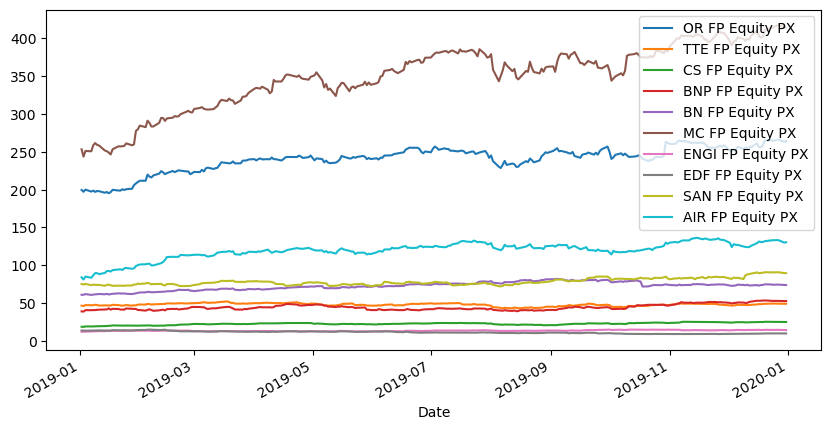

In [15]:
agg_price_data_2019_10 = agg_price_mktcap_data_2019_10_highest.T.filter(like = 'PX', axis=0).T
agg_mkcap_data_2019_10 = agg_price_mktcap_data_2019_10_highest.T.filter(like = 'MKTCAP', axis=0).T
agg_price_data_2019_10.plot(figsize=(10,5))
plt.show()

<h3> Portfolio Strategies </h3>

In this part, we are going to compare in terms of Sharpe ratio and maximum drawdown, the respective performance of the three following portfolios over the year 2019:
- An equally-weighted portfolio.
- A Markowitz minimum-variance portfolio.
- An ERC portfolio.

In [16]:
#building our returns over 2019
returns = agg_price_data_2019_10.pct_change().dropna()

In [17]:
#parametering the plot
fontsize = 9
width_in_cm = 14.
params = {'figure.figsize': (width_in_cm / 2.54, width_in_cm / 2.54 * 9./16.),
          'axes.labelsize': fontsize,
          'axes.titlesize': fontsize,
          'xtick.labelsize': fontsize*0.75,
          'ytick.labelsize': fontsize*0.75,
          'legend.fontsize': fontsize*0.75}
plt.rcParams.update(params)

In [18]:
#preparing the essential Strategy classe that will be used to build the different portfolios and has common functions and propreties
class Strategy:

    def __init__(self, name, returns, prices):
        self.name = name
        self.returns = returns
        self.prices = prices
        self.pnl = np.c_[np.array([1000000.]), 1000000.*np.cumprod(1.+returns.to_numpy()).reshape(1,-1)].flatten()
    def show(self):
        return pd.DataFrame(self.returns)

    def show_covariance_matrix(self):
        return sn.heatmap(self.prices.corr(),annot=True,cmap='OrRd')

    def volatility(self):
        return np.std(self.returns)*np.sqrt(252)

    def sharpe_ratio(self):
        return np.mean(self.returns)*np.sqrt(252)/np.std(self.returns)

    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)

    def max_dd_2(self):
        return np.max(1. - self.pnl/np.maximum.accumulate(self.pnl))

    def illustrate(self):
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.returns.index, self.pnl[1:], 'b', label=self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
                                                          (self.volatility(), self.sharpe_ratio(), self.max_dd()))
        ax.set_xlabel('Time')
        ax.set_ylabel('PnL')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'PnL of the strategy {self.name}')
        ax.grid(axis='x', linestyle='--')
        fig.tight_layout()
        fig.savefig(f'{self.name}.pdf')
        plt.show()
        
    def comparison_strategies(strategies):
        fig, ax = plt.subplots(1, 1)
        for strategy in strategies:
            ax.plot(strategy.returns.index, strategy.pnl[1:], label=strategy.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)' %
                                                                            (strategy.volatility(), strategy.sharpe_ratio(), strategy.max_dd()))

        ax.set_xlabel('Time')
        ax.set_ylabel('PnL')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_title('PnL of the strategies')
        ax.grid(axis='x', linestyle='--')
        fig.tight_layout()
        plt.show()

#### Equally-weighted Portfolio 

In [19]:
#code that computes the returns of the Equally-weighted Portfolio
class EquallyWeighted(Strategy):

    def __init__(self, name, returns):
        weights_EW = np.full((len(returns), len(returns.columns)), 0.1, dtype=float) #equal weights 1/10
        returns_EW = (returns * weights_EW).sum(axis=1)
        super().__init__(name, returns_EW, returns)

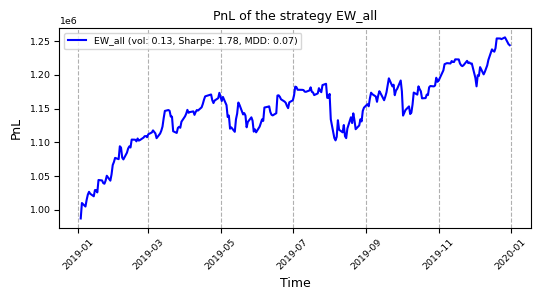

,0
Date,
2019-01-03,-0.012931
2019-01-04,0.023201
2019-01-07,-0.005141
2019-01-08,0.009914
2019-01-09,0.007571
...,...
2019-12-23,-0.000077
2019-12-24,-0.000749
2019-12-27,0.002111


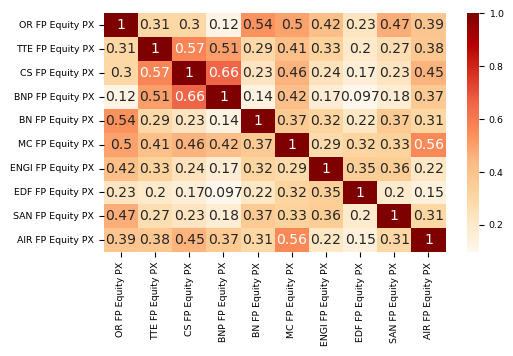

In [20]:
ew_port = EquallyWeighted('EW_all', returns)
ew_port.illustrate()
ew_port.show_covariance_matrix() #plot the covariance to observe the correlations between prices
ew_port.show() #show the portfolio

<h4>Markowitz minimum-variance Portfolio</h4>

In this section, we are going to compute the  empirical covariance matrix over 2017-2018, used for the 2 last portfolios.

In [21]:
#data over 2017 and 2018
agg_price_mktcap_data_over_2017_2018 = agg_data.loc[(agg_data.index >= '31/12/2016') & (agg_data.index <= '31/12/2018')]
agg_price_mktcap_data_over_2017_2018_10_highest = agg_price_mktcap_data_over_2017_2018[highest_columns_10]
agg_price_data_over_2017_2018_10 = agg_price_mktcap_data_over_2017_2018_10_highest.T.filter(like = 'PX', axis=0).T
agg_price_data_over_2017_2018_10['MC FP Equity PX'].fillna(method = 'bfill', inplace = True)
#covariance 2017 2018
returns_2017_2018 = agg_price_data_over_2017_2018_10.pct_change().dropna() # set returns to 0 when the stock disappears
emp_cov = EmpiricalCovariance().fit(returns_2017_2018)
cov = emp_cov.covariance_

/var/folders/ct/1jcf3_210l7761kmjs9wb7km0000gn/T/ipykernel_43464/2201598525.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  agg_price_mktcap_data_over_2017_2018 = agg_data.loc[(agg_data.index >= '31/12/2016') & (agg_data.index <= '31/12/2018')]


In [22]:
class markowitzMinimumVariance(Strategy):

    def __init__(self, name, returns,weightsOptimized):
        returns_MMV = (returns * weightsOptimized).sum(axis=1) #using the optimized weights generetad by MPT function
        super().__init__(name, returns_MMV, returns)

In [23]:
def weight_creator(df): #creating weights randomly
        weights = abs(np.random.randn(len(df.columns)))
        weights = weights / np.sum(weights)
        return weights
def MPT(df, cov): #generating weights corresponding to the min variance
    def returnsMPT(df, weights): #computing mean returns
        MeanReturns = df.mean()
        return np.dot(MeanReturns, weights)
    def portfolioRisk(weights, covMatrix): #computing the risk which is proportional to variance
        return np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))*np.sqrt(252)
    weights = []
    returns_MPT = []
    risks = []
    def optimizeWeightsMPT(df): #loop to generate weights and stock the chosen ones besides the variances values
        for i in range(10000):
            w = weight_creator(df)
            weights.append(w)
            returns_MPT.append(returnsMPT(df, w))
            risks.append(portfolioRisk(w, cov))
    optimizeWeightsMPT(df)
    Weights_minRisk = weights[risks.index(min(risks))]
    return Weights_minRisk

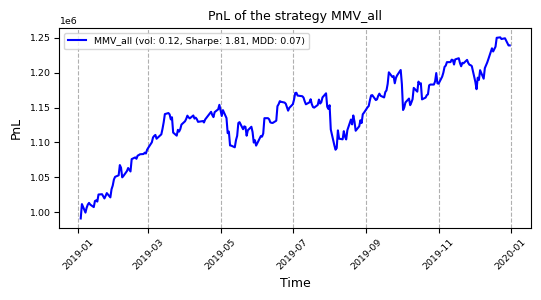

,0
Date,
2019-01-03,-0.009110
2019-01-04,0.020804
2019-01-07,-0.012080
2019-01-08,0.007035
2019-01-09,0.004541
...,...
2019-12-23,0.000511
2019-12-24,-0.001906
2019-12-27,0.000836


In [24]:
mmv_port = markowitzMinimumVariance('MMV_all', returns, MPT(returns, cov))
mmv_port.illustrate()
mmv_port.show()

<h4>ERC Portfolio</h4>

In [25]:
class EqualRiskContribution(Strategy):

    def __init__(self, name, returns, weightsOptimized):
        returns_ERC = (returns * weightsOptimized).sum(axis=1)
        super().__init__(name, returns_ERC, returns)

First method : the Riskfolio solution.

In [26]:
def ERC1(df):
    port = rp.HCPortfolio(returns=df)
    model='HERC'
    correlation = 'pearson'
    rm = 'MV'
    rf = 0
    linkage = 'ward'
    max_k = 10
    leaf_order = True
    w = port.optimization(model=model,
                          correlation=correlation,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)
    return w.T.to_numpy()

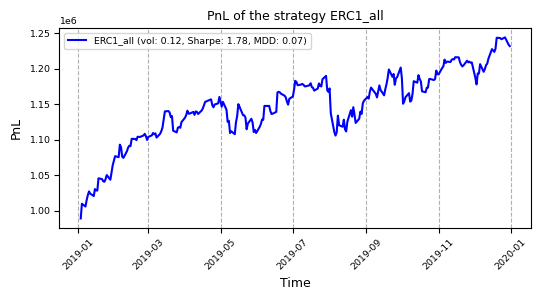

,0
Date,
2019-01-03,-0.010609
2019-01-04,0.020904
2019-01-07,-0.003889
2019-01-08,0.009053
2019-01-09,0.006861
...,...
2019-12-23,-0.000409
2019-12-24,-0.001320
2019-12-27,0.002164


In [27]:
erc1_port = EqualRiskContribution('ERC1_all', returns, ERC1(returns))
erc1_port.illustrate()
erc1_port.show()

Second method : the numerical solution.

To build the ERC portfolio, we are going to minimise the following function :

$$ \sum_{i=1}^n \sum_{j=1}^n(w_i(Σw)_i - w_j(Σw)_j)^2 $$

Where :
- $ (w)_i $ is the i-th composant of the weights vector.
- $ (Σw)_i $ is the i-th row of the vector issued from the product of the covariance matrix and the weights verctor.

Constraints : 
- Sum of weights is equal to one.
- Positive weights.

In [36]:
def ERC2(df, cov) :
    def sqp(weights, covMatrix): #code the Sequential Quadratic Programming function
        marginal_risk = covMatrix @ weights
        sqp_value = 0
        for i in range(len(weights)):
            for j in range(len(weights)):
                sqp_value += ((weights[i] * marginal_risk[i]) - (weights[j] * marginal_risk[j])) ** 2
        return sqp_value
    def min_risk_diff(weights, covMatrix): #choosing weights that minimize the variance of the rescaled risk contributions 
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds = len(weights) * [(0, 1),]
        result = minimize(lambda w: sqp(weights, covMatrix),
                   weights, bounds=bnds, constraints=constraints)
        return result.x
    weights = []
    sqp_v = []
    def optimizeWeightsERC(df): #loop to generate weights and stock the chosen ones besides the variances values
        for i in range(10000):
            w = min_risk_diff(weight_creator(df), cov)
            weights.append(w)
            sqp_v.append(sqp(w, cov))
    optimizeWeightsERC(df)
    Weights_minRisk = weights[sqp_v.index(min(sqp_v))]
    return Weights_minRisk

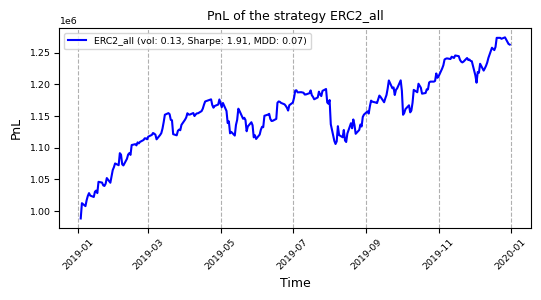

,0
Date,
2019-01-03,-0.011746
2019-01-04,0.024403
2019-01-07,-0.004563
2019-01-08,0.009353
2019-01-09,0.006609
...,...
2019-12-23,-0.000010
2019-12-24,-0.001152
2019-12-27,0.001787


In [37]:
erc2_port = EqualRiskContribution('ERC2_all', returns, ERC2(returns, cov))
erc2_port.illustrate()
erc2_port.show()

### Performance comparison

As we can observe, the third strategy has the highest Sharpe Ratio over 2019. Results can be different due to randomness of weights in the 2 last strategies.

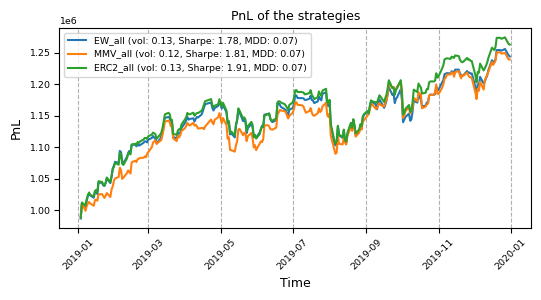

In [38]:
Strategy.comparison_strategies([ew_port, mmv_port, erc2_port])